In [1]:
import datetime as dt
import itertools
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

from collections import OrderedDict
from functools import reduce

In [2]:
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 300
pd.options.display.max_columns = 50

In [3]:
capitais = ['centro',
            'rio branco',
            'maceió',
            'maceio'
            'macapá',
            'macapa',
            'manaus',
            'salvador',
            'fortaleza',
            'brasília',
            'brasilia',
            'vitória',
            'vitoria',
            'goiânia',
            'goiania',
            'são luís',
            'sao luis',
            'são luis',
            'são luiz',
            'cuiabá',
            'cuiaba',
            'campo grande',
            'belo horizonte',
            '  belo horizonte',
            'belém',
            'belem',
            'joão pessoa',
            'joao pessoa',
            'curitiba',
            'curitiba ',
            'recife',
            'teresina',
            'rio de janeiro',
            'rio  de janeiro',
            'rio de jeneiro',
            'rj',
            'natal',
            'porto alegre',
            'porto velho',
            'boa vista',
            'florianópolis',
            'florianopolis',
            'são paulo',
            'sao paulo',
            'sao paulo ',
            'são paulo ',
            'aracaju',
            'palmas']

In [4]:
map_dept = {6: 'VESTUÁRIO',
            8: 'CALÇADOS / BOLSAS / MALAS',
            9: 'CAMA / MESA / BANHO / UTILIDADES DOMÉSTICAS',
            25: 'ARTIGOS',
            36: 'ÓTICA',
            45: 'MÓVEIS'}

In [5]:
dia_da_semana_dict = {1: 'S', 2: 'T', 3: 'Q', 4: 'Q', 5: 'S', 6: 'S', 7: 'D'}

In [6]:
def augment_df(df):
    df['mes'] = df['dia'].apply(lambda x: x.month)
    df['dia_da_semana'] = df['dia'].apply(lambda x: x.isoweekday())
    df['semana'] = df['dia'].apply(lambda x: x.isocalendar()[1])
    
    try:
        df['capital'] = df['cidade'].isin(capitais)
    except:
        pass

    return df

In [7]:
def modify_df(df):
    df['dia_da_semana'] = df['dia_da_semana'].map(dia_da_semana_dict)
    df['mes_mod'] = [1]*28 + [2]*28 + [3]*28
    df['semana_mod'] = \
    np.tile(
        reduce(
            lambda x, y: x + y, [[i % 5]*7 for i in range(1, 5)]), 3)

    return df

In [8]:
def get_delta_df(df_diff, col):
    diff = {}

    delta_11 = df_diff.loc[8, col] / df_diff.loc[0, col]
    diff['delta_11'] = \
    str(round(100 * (delta_11 - 1), 2)).replace('.', ',') + '%'
    delta_12 = df_diff.loc[9, col] / df_diff.loc[1, col]
    diff['delta_12'] = \
    str(round(100 * (delta_12 - 1), 2)).replace('.', ',') + '%'
    delta_13 = df_diff.loc[10, col] / df_diff.loc[2, col]
    diff['delta_13'] = \
    str(round(100 * (delta_13 - 1), 2)).replace('.', ',') + '%'
    delta_14 = df_diff.loc[11, col] / df_diff.loc[3, col]
    diff['delta_14'] = \
    str(round(100 * (delta_14 - 1), 2)).replace('.', ',') + '%'

    delta_21 = df_diff.loc[8, col] / df_diff.loc[4, col]
    diff['delta_21'] = \
    str(round(100 * (delta_21 - 1), 2)).replace('.', ',') + '%'
    delta_22 = df_diff.loc[9, col] / df_diff.loc[5, col]
    diff['delta_22'] = \
    str(round(100 * (delta_22 - 1), 2)).replace('.', ',') + '%'
    delta_23 = df_diff.loc[10, col] / df_diff.loc[6, col]
    diff['delta_23'] = \
    str(round(100 * (delta_23 - 1), 2)).replace('.', ',') + '%'
    delta_24 = df_diff.loc[11, col] / df_diff.loc[7, col]
    diff['delta_24'] = \
    str(round(100 * (delta_24 - 1), 2)).replace('.', ',') + '%'

    diff = {k: [v, color_negative_red_charts(v)] for k, v in diff.items()}

    return diff

In [9]:
def color_negative_red_charts(value):
    if value.startswith('-') and value.endswith('%'):
        color = 'red'
    elif value.endswith('%'):
        color = 'green'
    else:
        color = 'black'

    return color

In [10]:
def impute_missing_estados(df, state, missing_date):
    ts = ((missing_date - np.datetime64('1970-01-01T00:00:00Z')) / 
          np.timedelta64(1, 's'))
    dia_dt = dt.datetime.utcfromtimestamp(ts)
    df_imputed = df.append({'state': state,
                            'dia': dia_dt,
                            'tot_compra': 0,
                            'mes': dia_dt.month,
                            'dia_da_semana': dia_dt.isoweekday(),
                            'semana': dia_dt.isocalendar()[1]},
                           ignore_index=True)
    return df_imputed

In [11]:
def color_negative_red_tables(value):
    if value.startswith('-') and value.endswith('%'):
        color = 'red'
    elif value.endswith('%'):
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

<font size="5">**RELATÓRIO DE IMPACTO DO COVID-19 NAS COMPRAS**</font>

In [12]:
# ATUALIZAR ABAIXO ANTES DE GERAR O RELATÓRO!!!

Períodos:
2. $M_{-2} \rightarrow$ 06/02/2020 a 04/03/2020 (28 dias)
3. $M_{-1} \rightarrow$ 05/03/2020 a 01/04/2020 (28 dias)
4. $M_{0} \rightarrow$ 02/04/2020 a 29/04/2020 (28 dias)

In [13]:
df_compras = (pd
             .read_csv('data/cielo_compra.csv', parse_dates=['dia'])
             .sort_values('dia')
             .dropna(axis=0)
             .reset_index(drop=True))
df_compras = augment_df(df_compras)

In [14]:
df_ref = df_compras.copy()

In [15]:
# ATUALIZAR ABAIXO ANTES DE GERAR O RELATÓRO!!!
inicio_analise, fim_analise = '2020-02-06', '2020-04-29'
dias = pd.DataFrame(pd.date_range(inicio_analise, fim_analise), columns=['dia'])
df = df_compras[(df_compras['dia'] >= inicio_analise) & (df_compras['dia'] <= fim_analise)]

# ATUALIZAR ABAIXO ANTES DE GERAR O RELATÓRO!!!
inicio_mes_corrente, fim_mes_corrente = '2020-04-02', '2020-04-29'
dias_3 = pd.DataFrame(pd.date_range(inicio_mes_corrente, fim_mes_corrente), columns=['dia'])
df_3 = df_compras[(df_compras['dia'] >= inicio_mes_corrente) & (df_compras['dia'] <= fim_mes_corrente)]

# ATUALIZAR ABAIXO ANTES DE GERAR O RELATÓRO!!!
# PERÍODO DE REFERÊNCIA PRÉ-COVID, PRÉ-CARNAVAL
inicio_mes_ref, fim_mes_ref = '2020-01-23', '2020-02-19'
dias_0 = pd.DataFrame(pd.date_range(inicio_mes_ref, fim_mes_ref), columns=['dia'])
df_0 = df_compras[(df_compras['dia'] >= inicio_mes_ref) & (df_compras['dia'] <= fim_mes_ref)]

# Brasil

In [16]:
df_brasil = \
modify_df(
    augment_df(
        pd.DataFrame(df.groupby('dia')['tot_compra'].sum())
        .reset_index()))

In [17]:
dia_ref_0 = df_brasil.loc[56, 'dia'].strftime('%d/%m')
dia_ref_1 = df_brasil.loc[83, 'dia'].strftime('%d/%m')

In [18]:
df_diff = (df_brasil
           .groupby(['mes_mod', 'semana_mod'])['tot_compra']
           .sum()
           .reset_index())

In [19]:
diff = get_delta_df(df_diff, 'tot_compra')

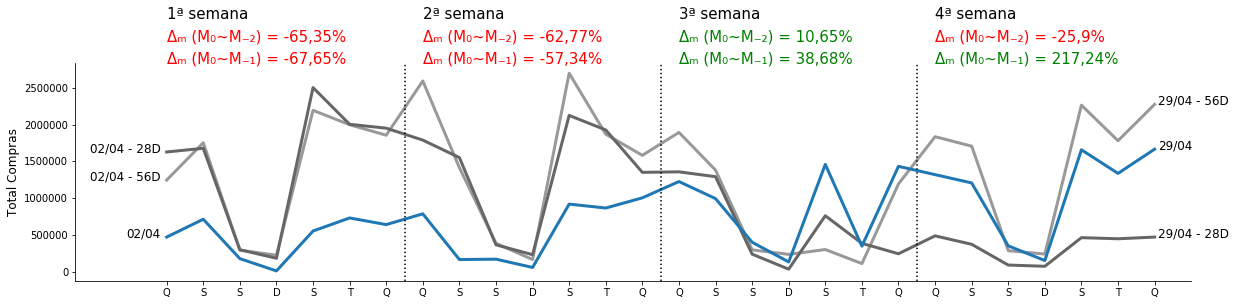

In [20]:
df_brasil_1 = df_brasil[df_brasil['mes_mod'] == 1].reset_index(drop=True)
df_brasil_2 = df_brasil[df_brasil['mes_mod'] == 2].reset_index(drop=True)
df_brasil_3 = df_brasil[df_brasil['mes_mod'] == 3].reset_index(drop=True)

n_dias = len(df_brasil_1)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_brasil_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_brasil_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_brasil_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_brasil_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 6 * 10**5, '1ª semana', size=15)
ax.text(0,
        y_max + 3 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 6 * 10**5, '2ª semana', size=15)
ax.text(7,
        y_max + 3 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 6 * 10**5, '3ª semana', size=15)
ax.text(14,
        y_max + 3 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 6 * 10**5, '4ª semana', size=15)
ax.text(21,
        y_max + 3 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_brasil_1.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_brasil_2.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_brasil_3.loc[0, 'tot_compra']),
            size=12)

ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_brasil_1.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_brasil_2.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_brasil_3.loc[n_dias-1, 'tot_compra']),
            size=12)

ax.set_ylabel('Total Compras', size=12)

plt.savefig('imagens/brasil.png')

## Por Tamanho das Redes

In [21]:
redes_peq = (df[['id', 'client_id']]
             .drop_duplicates()
             .groupby('client_id')['id']
             .count())
redes_peq.where(redes_peq == 1, 0, inplace=True)
redes_grd = redes_peq[redes_peq == 0].index
df['rede_peq'] = 1
df['rede_peq'].mask(df['client_id'].isin(redes_grd), 0, inplace=True)

In [22]:
df_redes = \
augment_df(
    pd.DataFrame(
        df.groupby(
            ['rede_peq', 'dia'])['tot_compra'].sum()).reset_index())

### Redes Pequenas (1 Loja)

In [23]:
df_redes_peq = modify_df(df_redes[df_redes['rede_peq'] == 1])

df_diff = (df_redes_peq
           .groupby(['mes_mod', 'semana_mod'])['tot_compra']
           .sum()
           .reset_index())
diff = get_delta_df(df_diff, 'tot_compra')

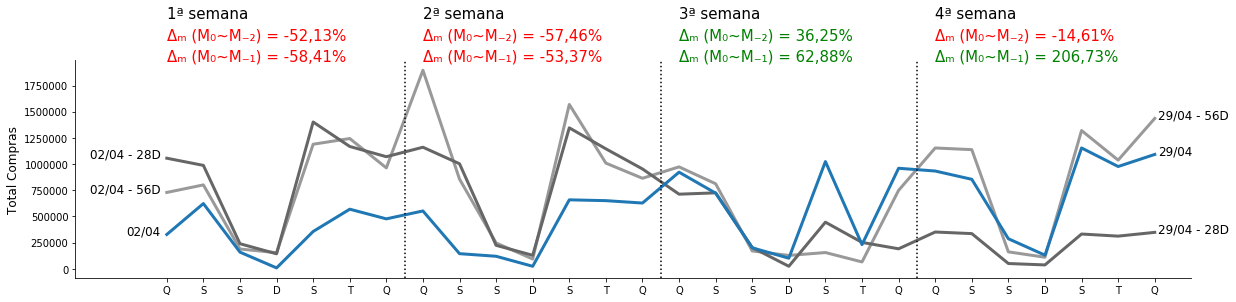

In [24]:
df_redes_peq_1 = df_redes_peq[df_redes_peq['mes_mod'] == 1].reset_index(drop=True)
df_redes_peq_2 = df_redes_peq[df_redes_peq['mes_mod'] == 2].reset_index(drop=True)
df_redes_peq_3 = df_redes_peq[df_redes_peq['mes_mod'] == 3].reset_index(drop=True)

n_dias = len(df_redes_peq_1)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_redes_peq_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_redes_peq_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_redes_peq_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_redes_peq_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 4 * 10**5, '1ª semana', size=15)
ax.text(0,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 4 * 10**5, '2ª semana', size=15)
ax.text(7,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 4 * 10**5, '3ª semana', size=15)
ax.text(14,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 4 * 10**5, '4ª semana', size=15)
ax.text(21,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_redes_peq_1.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_redes_peq_2.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_redes_peq_3.loc[0, 'tot_compra']),
            size=12)

ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_redes_peq_1.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_redes_peq_2.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_redes_peq_3.loc[n_dias-1, 'tot_compra']),
            size=12)

ax.set_ylabel('Total Compras', size=12)

plt.savefig('imagens/redes_peq.png')

### Redes Grandes (2+ Lojas)

In [25]:
df_redes_grd = modify_df(df_redes[df_redes['rede_peq'] == 0])

df_diff = (df_redes_grd
           .groupby(['mes_mod', 'semana_mod'])['tot_compra']
           .sum()
           .reset_index())
diff = get_delta_df(df_diff, 'tot_compra')

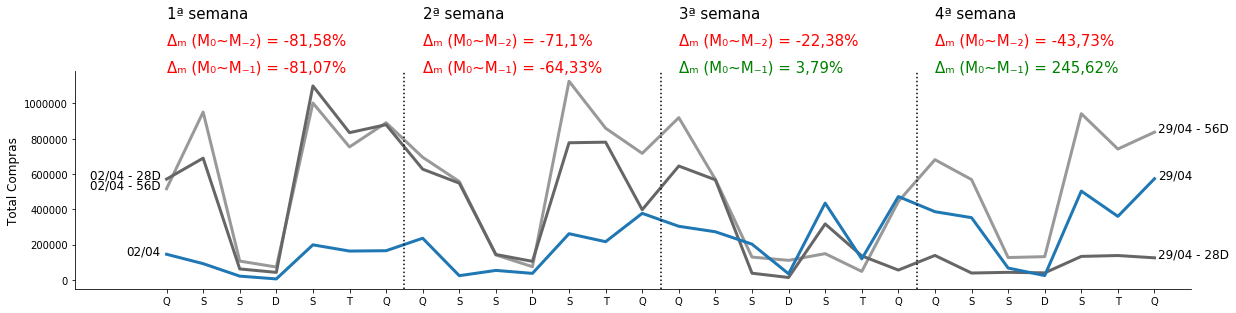

In [26]:
df_redes_grd_1 = df_redes_grd[df_redes_grd['mes_mod'] == 1].reset_index(drop=True)
df_redes_grd_2 = df_redes_grd[df_redes_grd['mes_mod'] == 2].reset_index(drop=True)
df_redes_grd_3 = df_redes_grd[df_redes_grd['mes_mod'] == 3].reset_index(drop=True)

n_dias = len(df_redes_grd_1)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_redes_grd_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_redes_grd_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_redes_grd_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_redes_grd_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 3 * 10**5, '1ª semana', size=15)
ax.text(0,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 3 * 10**5, '2ª semana', size=15)
ax.text(7,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 3 * 10**5, '3ª semana', size=15)
ax.text(14,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 3 * 10**5, '4ª semana', size=15)
ax.text(21,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_redes_grd_1.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_redes_grd_2.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_redes_grd_3.loc[0, 'tot_compra']),
            size=12)

ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_redes_grd_1.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_redes_grd_2.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_redes_grd_3.loc[n_dias-1, 'tot_compra']),
            size=12)

ax.set_ylabel('Total Compras', size=12)

plt.savefig('imagens/redes_grd.png')

## Por Departamentos

In [27]:
df_brasil_dept = \
augment_df(
    pd.DataFrame(
        df.groupby(
            ['department_id', 'dia'])['tot_compra'].sum()).reset_index())

df_brasil_dept_dict = \
{6: df_brasil_dept[df_brasil_dept['department_id'] == 6],
 
 8: (df_brasil_dept[df_brasil_dept['department_id'] == 8]
     .reset_index(drop=True)),
 
 9: (df_brasil_dept[df_brasil_dept['department_id'] == 9]
     .reset_index(drop=True)),
 
 25: (df_brasil_dept[df_brasil_dept['department_id'] == 25]
      .reset_index(drop=True)),
 
 36: (df_brasil_dept[df_brasil_dept['department_id'] == 36]
      .reset_index(drop=True)),
 
 45: (df_brasil_dept[df_brasil_dept['department_id'] == 45]
      .reset_index(drop=True))}

df_diff = {}
for d in [6, 8, 9, 25, 36, 45]:
    df_brasil_dept_dict[d] = dias.merge(df_brasil_dept_dict[d], on = 'dia', how = 'outer')
    df_brasil_dept_dict[d]['department_id'].fillna(d, inplace=True)
    df_brasil_dept_dict[d]['tot_compra'].fillna(0, inplace=True)
    df_brasil_dept_dict[d]['mes'].fillna(df_brasil_dept_dict[d]['dia']
                                         .apply(lambda x: x.month),
                                         inplace=True)
    df_brasil_dept_dict[d]['dia_da_semana'].fillna(df_brasil_dept_dict[d]['dia']
                                                   .apply(lambda x: x.isoweekday()),
                                                   inplace=True)
    df_brasil_dept_dict[d]['semana'].fillna(df_brasil_dept_dict[d]['dia']
                                            .apply(lambda x: x.isocalendar()[1]),
                                            inplace=True)
    df_brasil_dept_dict[d] = modify_df(df_brasil_dept_dict[d])
    df_diff[d] = (df_brasil_dept_dict[d]
                  .groupby(['mes_mod', 'semana_mod'])['tot_compra']
                  .sum()
                  .reset_index())

In [28]:
diff = {d: get_delta_df(df_diff[d], 'tot_compra') for d in [6, 8, 9, 25, 36, 45]}

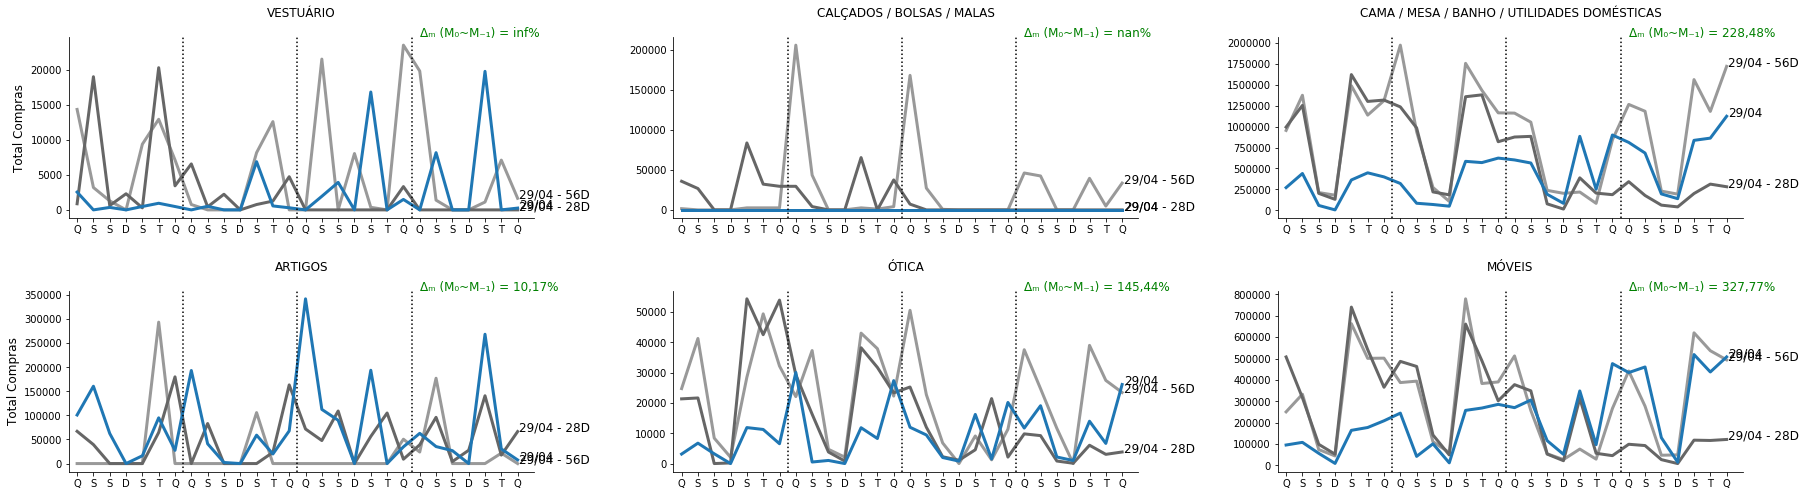

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(30, 8))
loc = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for i, d in enumerate([6, 8, 9, 25, 36, 45]):
    df_brasil_1 = \
    (df_brasil_dept_dict[d][df_brasil_dept_dict[d]['mes_mod'] == 1]
     .reset_index(drop=True))
    df_brasil_2 = \
    (df_brasil_dept_dict[d][df_brasil_dept_dict[d]['mes_mod'] == 2]
     .reset_index(drop=True))
    df_brasil_3 = \
    (df_brasil_dept_dict[d][df_brasil_dept_dict[d]['mes_mod'] == 3]
     .reset_index(drop=True))

    sns.lineplot(x=range(n_dias),
                 y='tot_compra',
                 data=df_brasil_1,
                 color='0.6',
                 lw=3,
                 ax=ax[loc[i]])
    sns.lineplot(x=range(n_dias),
                 y='tot_compra',
                 data=df_brasil_2,
                 color='0.4',
                 lw=3,
                 ax=ax[loc[i]])
    sns.lineplot(x=range(n_dias),
                 y='tot_compra',
                 data=df_brasil_3,
                 lw=3,
                 ax=ax[loc[i]])

    ax[loc[i]].set_title(map_dept[d], pad=20)
    ax[loc[i]].set_xlim(-0.5, n_dias)
    ax[loc[i]].set_xticks(range(n_dias))
    ax[loc[i]].set_xticklabels(df_brasil_1['dia_da_semana'])
    
    ax[loc[i]].axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
    ax[loc[i]].axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
    ax[loc[i]].axvline(20.5, ymin=0, ymax=200, color='0', ls=':')
    
    ax[loc[i]].spines['right'].set_visible(False)
    ax[loc[i]].spines['top'].set_visible(False)
    
    if i in [0, 3]:
        ax[loc[i]].set_ylabel('Total Compras', size=12)
    else:
        ax[loc[i]].set_ylabel('')
        
    ax[loc[i]].annotate(f'{dia_ref_1} - 56D',
                        (n_dias-0.9, df_brasil_1.loc[n_dias-1, 'tot_compra']),
                        size=12)
    ax[loc[i]].annotate(f'{dia_ref_1} - 28D',
                        (n_dias-0.9, df_brasil_2.loc[n_dias-1, 'tot_compra']),
                        size=12)
    ax[loc[i]].annotate(f'{dia_ref_1}',
                        (n_dias-0.9, df_brasil_3.loc[n_dias-1, 'tot_compra']),
                        size=12)

    y_max = ax[loc[i]].get_ylim()[1]
    ax[loc[i]].text(21,
                    y_max,
                    '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(
                        diff[d]['delta_24'][0]),
                    size=12,
                    color=diff[d]['delta_24'][1])

plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig('imagens/brasil_dept_{}.png'.format(d))

## Por Total Compras Médio

In [30]:
df_ticket_medio = \
modify_df(
    augment_df(
        pd.DataFrame(df.groupby('dia')['tot_compra'].mean())
        .reset_index()))

In [31]:
df_diff = (df_ticket_medio
           .groupby(['mes_mod', 'semana_mod'])['tot_compra']
           .sum()
           .reset_index())

In [32]:
diff = get_delta_df(df_diff, 'tot_compra')

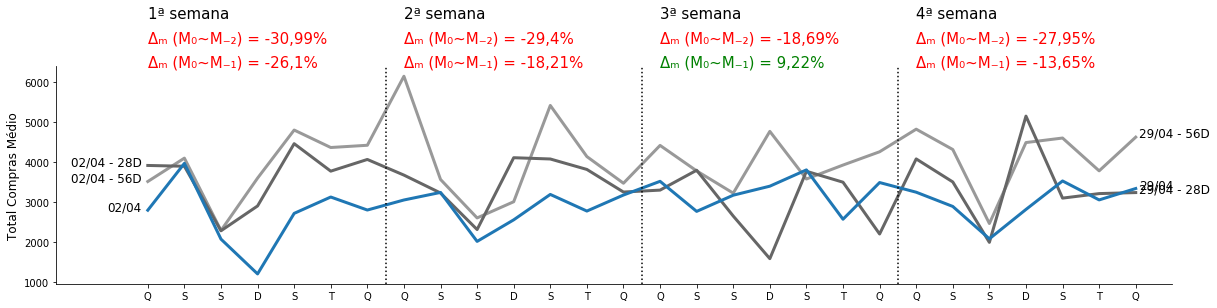

In [33]:
df_ticket_medio_1 = df_ticket_medio[df_ticket_medio['mes_mod'] == 1].reset_index(drop=True)
df_ticket_medio_2 = df_ticket_medio[df_ticket_medio['mes_mod'] == 2].reset_index(drop=True)
df_ticket_medio_3 = df_ticket_medio[df_ticket_medio['mes_mod'] == 3].reset_index(drop=True)

n_dias = len(df_ticket_medio_1)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_ticket_medio_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_ticket_medio_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_ticket_medio_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_ticket_medio_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 12 * 10**2, '1ª semana', size=15)
ax.text(0,
        y_max + 6 * 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 12 * 10**2, '2ª semana', size=15)
ax.text(7,
        y_max + 6 * 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 12 * 10**2, '3ª semana', size=15)
ax.text(14,
        y_max + 6 * 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 12 * 10**2, '4ª semana', size=15)
ax.text(21,
        y_max + 6 * 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_ticket_medio_1.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_ticket_medio_2.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_ticket_medio_3.loc[0, 'tot_compra']),
            size=12)

ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_ticket_medio_1.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_ticket_medio_2.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_ticket_medio_3.loc[n_dias-1, 'tot_compra']),
            size=12)

ax.set_ylabel('Total Compras Médio', size=12)

plt.savefig('imagens/ticket_medio.png')

## Por Número de Transações

In [34]:
df_transacoes = \
modify_df(
    augment_df(
        pd
        .DataFrame(df.groupby('dia')['quantidade_de_compras'].sum())
        .reset_index()))

In [35]:
df_diff = (df_transacoes
           .groupby(['mes_mod', 'semana_mod'])['quantidade_de_compras']
           .sum()
           .reset_index())

In [36]:
diff = get_delta_df(df_diff, 'quantidade_de_compras')

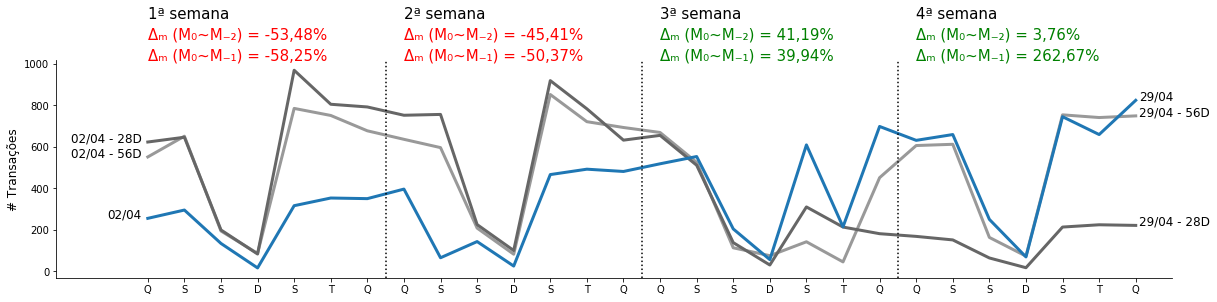

In [37]:
df_transacoes_1 = df_transacoes[df_transacoes['mes_mod'] == 1].reset_index(drop=True)
df_transacoes_2 = df_transacoes[df_transacoes['mes_mod'] == 2].reset_index(drop=True)
df_transacoes_3 = df_transacoes[df_transacoes['mes_mod'] == 3].reset_index(drop=True)

n_dias = len(df_transacoes_1)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='quantidade_de_compras',
             data=df_transacoes_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='quantidade_de_compras',
             data=df_transacoes_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='quantidade_de_compras',
             data=df_transacoes_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_transacoes_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 2 * 10**2, '1ª semana', size=15)
ax.text(0,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 2 * 10**2, '2ª semana', size=15)
ax.text(7,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 2 * 10**2, '3ª semana', size=15)
ax.text(14,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 2 * 10**2, '4ª semana', size=15)
ax.text(21,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_transacoes_1.loc[0, 'quantidade_de_compras']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_transacoes_2.loc[0, 'quantidade_de_compras']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_transacoes_3.loc[0, 'quantidade_de_compras']),
            size=12)

ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_transacoes_1.loc[n_dias-1, 'quantidade_de_compras']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_transacoes_2.loc[n_dias-1, 'quantidade_de_compras']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_transacoes_3.loc[n_dias-1, 'quantidade_de_compras']),
            size=12)

ax.set_ylabel('# Transações', size=12)

plt.savefig('imagens/transacoes.png')

## Por Número de Fornecedores Ativos

In [38]:
n_ativos = []
for d in dias.squeeze(1):
    n_ativos.append(len(df_ref.loc[
        (df_ref['dia'] > d - dt.timedelta(30)) &
        (df_ref['dia'] <= d), 'id'].unique()))
    
df_ativos = pd.DataFrame({'dia': dias.squeeze(1), 'fornecedores_ativos': n_ativos})

In [39]:
df_ativos = modify_df(augment_df(df_ativos))

In [40]:
df_diff = (df_ativos
           .groupby(['mes_mod', 'semana_mod'])['fornecedores_ativos']
           .sum()
           .reset_index())

In [41]:
diff = get_delta_df(df_diff, 'fornecedores_ativos')

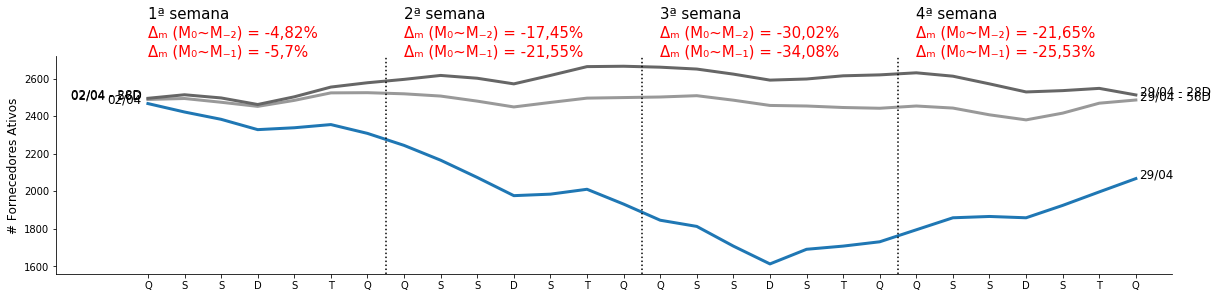

In [42]:
df_ativos_1 = df_ativos[df_ativos['mes_mod'] == 1].reset_index(drop=True)
df_ativos_2 = df_ativos[df_ativos['mes_mod'] == 2].reset_index(drop=True)
df_ativos_3 = df_ativos[df_ativos['mes_mod'] == 3].reset_index(drop=True)

n_dias = len(df_ativos_1)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='fornecedores_ativos',
             data=df_ativos_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='fornecedores_ativos',
             data=df_ativos_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='fornecedores_ativos',
             data=df_ativos_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_ativos_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 2 * 10**2, '1ª semana', size=15)
ax.text(0,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 2 * 10**2, '2ª semana', size=15)
ax.text(7,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 2 * 10**2, '3ª semana', size=15)
ax.text(14,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 2 * 10**2, '4ª semana', size=15)
ax.text(21,
        y_max + 10**2,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_ativos_1.loc[0, 'fornecedores_ativos']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_ativos_2.loc[0, 'fornecedores_ativos']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_ativos_3.loc[0, 'fornecedores_ativos']),
            size=12)

ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_ativos_1.loc[n_dias-1, 'fornecedores_ativos']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_ativos_2.loc[n_dias-1, 'fornecedores_ativos']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_ativos_3.loc[n_dias-1, 'fornecedores_ativos']),
            size=12)

ax.set_ylabel('# Fornecedores Ativos', size=12)

plt.savefig('imagens/fornecedores_ativos.png')

# Capitais

In [43]:
df_capitais = \
(pd.DataFrame(df[df['capital'] == True].groupby('dia')['tot_compra'].sum())
 .reset_index())
df_capitais = modify_df(augment_df(df_capitais))

In [44]:
df_diff = (df_capitais.groupby(['mes_mod', 'semana_mod'])['tot_compra']
           .sum()
           .reset_index())

In [45]:
diff = get_delta_df(df_diff, 'tot_compra')

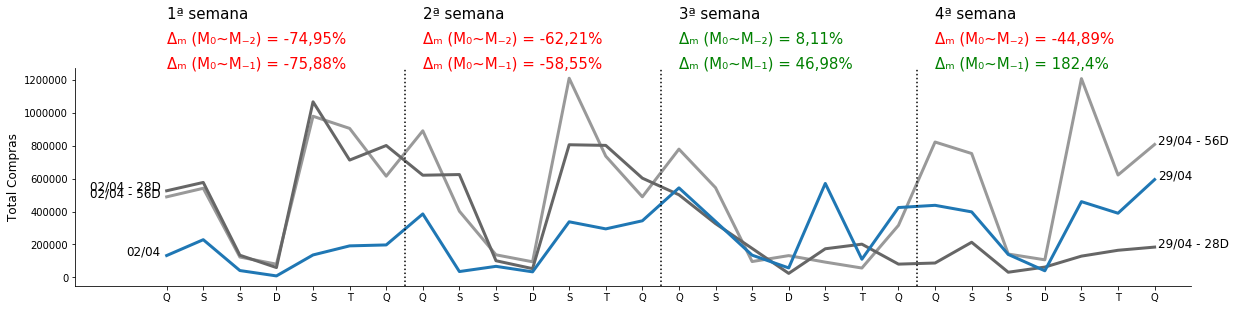

In [46]:
df_capitais_1 = df_capitais[df_capitais['mes_mod'] == 1].reset_index(drop=True)
df_capitais_2 = df_capitais[df_capitais['mes_mod'] == 2].reset_index(drop=True)
df_capitais_3 = df_capitais[df_capitais['mes_mod'] == 3].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_capitais_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_capitais_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_capitais_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_capitais_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 3 * 10**5, '1ª semana', size=15)
ax.text(0,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 3 * 10**5, '2ª semana', size=15)
ax.text(7,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 3 * 10**5, '3ª semana', size=15)
ax.text(14,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 3 * 10**5, '4ª semana', size=15)
ax.text(21,
        y_max + 1.5 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.set_ylabel('Total Compras', size=12)

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_capitais_1.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_capitais_2.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_capitais_3.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_capitais_1.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_capitais_2.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_capitais_3.loc[n_dias-1, 'tot_compra']),
            size=12)

plt.savefig('imagens/capitais.png')

# Não-Capitais

In [47]:
df_nao_capitais = \
(pd.DataFrame(df[df['capital'] == False].groupby('dia')['tot_compra'].sum())
 .reset_index())

df_nao_capitais = modify_df(augment_df(df_nao_capitais))

In [48]:
df_diff = (df_nao_capitais.groupby(['mes_mod', 'semana_mod'])['tot_compra']
           .sum()
           .reset_index())

In [49]:
diff = get_delta_df(df_diff, 'tot_compra')

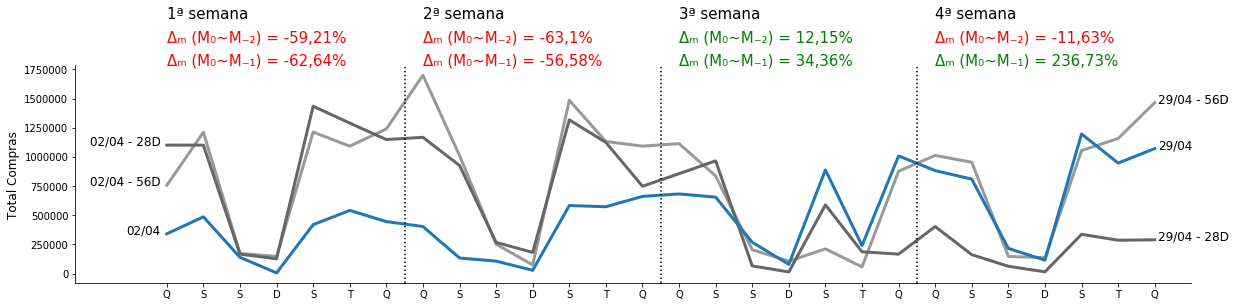

In [50]:
df_nao_capitais_1 = \
df_nao_capitais[df_nao_capitais['mes_mod'] == 1].reset_index(drop=True)
df_nao_capitais_2 = \
df_nao_capitais[df_nao_capitais['mes_mod'] == 2].reset_index(drop=True)
df_nao_capitais_3 = \
df_nao_capitais[df_nao_capitais['mes_mod'] == 3].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 4))

sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_nao_capitais_1,
             color='0.6',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_nao_capitais_2,
             color='0.4',
             lw=3,
             ax=ax)
sns.lineplot(x=range(n_dias),
             y='tot_compra',
             data=df_nao_capitais_3,
             lw=3,
             ax=ax)

y_max = ax.get_ylim()[1]

ax.set_xlim(-2.5, n_dias)
ax.set_xticks(range(n_dias))
ax.set_xticklabels(df_nao_capitais_1['dia_da_semana'])

ax.axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
ax.axvline(20.5, ymin=0, ymax=200, color='0', ls=':')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0, y_max + 4 * 10**5, '1ª semana', size=15)
ax.text(0,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_11'][0]),
        size=15,
        color=diff['delta_11'][1])
ax.text(0,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_21'][0]),
        size=15,
        color=diff['delta_21'][1])

ax.text(7, y_max + 4 * 10**5, '2ª semana', size=15)
ax.text(7,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_12'][0]),
        size=15,
        color=diff['delta_12'][1])
ax.text(7,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_22'][0]),
        size=15,
        color=diff['delta_22'][1])

ax.text(14, y_max + 4 * 10**5, '3ª semana', size=15)
ax.text(14,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_13'][0]),
        size=15,
        color=diff['delta_13'][1])
ax.text(14,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_23'][0]),
        size=15,
        color=diff['delta_23'][1])

ax.text(21, y_max + 4 * 10**5, '4ª semana', size=15)
ax.text(21,
        y_max + 2 * 10**5,
        '\u0394\u2098 (M\u2080~M\u208B\u2082) = {}'.format(diff['delta_14'][0]),
        size=15,
        color=diff['delta_14'][1])
ax.text(21,
        y_max,
        '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(diff['delta_24'][0]),
        size=15,
        color=diff['delta_24'][1])

ax.set_ylabel('Total Compras', size=12)

ax.annotate(f'{dia_ref_0} - 56D',
            (-2.1, df_nao_capitais_1.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0} - 28D',
            (-2.1, df_nao_capitais_2.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_0}',
            (-1.1, df_nao_capitais_3.loc[0, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 56D',
            (n_dias-0.9, df_nao_capitais_1.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1} - 28D',
            (n_dias-0.9, df_nao_capitais_2.loc[n_dias-1, 'tot_compra']),
            size=12)
ax.annotate(f'{dia_ref_1}',
            (n_dias-0.9, df_nao_capitais_3.loc[n_dias-1, 'tot_compra']),
            size=12)

plt.savefig('imagens/nao_capitais.png')

# Estados

In [51]:
estados_dict = {'bahia': 'ba',
                'so': 'sp',
                'sao paulo': 'sp',
                'são pauo': 'sp',
                'alagoas': 'al',
                'espírito santo': 'es',
                'vitoria': 'es',
                'paraná': 'pr',
                'são paulo': 'sp'}

In [52]:
mask = df['state'].isin(estados_dict.keys())
df.loc[mask, 'state'] = df.loc[mask, 'state'].map(estados_dict)
df.loc[df['state'] == 'so', 'state'] = 'sp'

In [53]:
estados = df['state'].unique()

In [54]:
df_estados = (pd.DataFrame(df.groupby(['state', 'dia'])['tot_compra'].sum())
              .reset_index())

df_estados = augment_df(df_estados)

In [55]:
df_estados_dict = {}
df_diff = {}
diff = {}
for e in estados:
    df_estados_dict[e] = \
    dias.merge(df_estados[df_estados['state'] == e],
               on='dia',
               how='outer')
    df_estados_dict[e]['state'].fillna(e, inplace=True)
    df_estados_dict[e]['tot_compra'].fillna(0, inplace=True)
    (df_estados_dict[e]['mes'].fillna(df_estados_dict[e]['dia']
                                      .apply(lambda x: x.month),
                                      inplace=True))
    df_estados_dict[e]['dia_da_semana'].fillna(df_estados_dict[e]['dia']
                                               .apply(lambda x: x.isoweekday()),
                                               inplace=True)
    df_estados_dict[e]['semana'].fillna(df_estados_dict[e]['dia']
                                        .apply(lambda x: x.isocalendar()[1]),
                                        inplace=True)
    df_estados_dict[e] = modify_df(df_estados_dict[e])

    df_diff[e] = (df_estados_dict[e]
                  .groupby(['mes_mod', 'semana_mod'])['tot_compra']
                  .sum()
                  .reset_index())
    
    diff[e] = get_delta_df(df_diff[e], 'tot_compra')

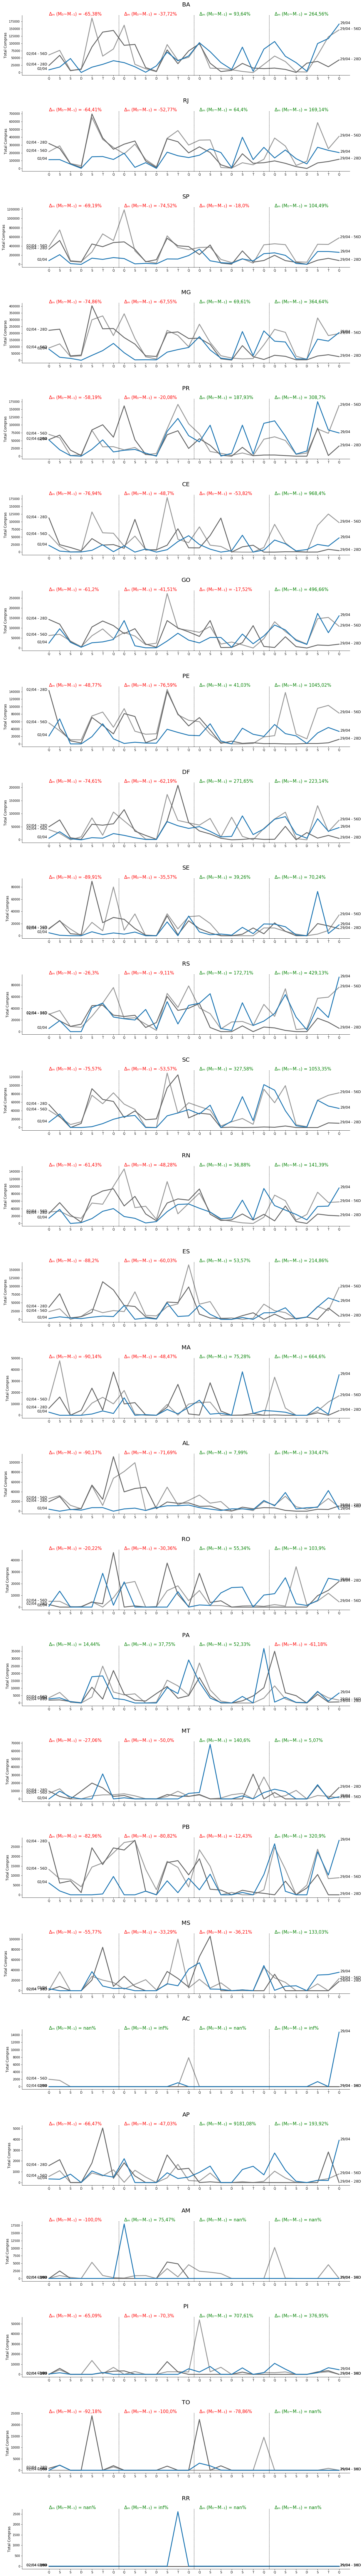

In [56]:
fig, ax = plt.subplots(27, 1, figsize=(20, 4*40))

for i, e in enumerate(estados):
    df_estados_1 = (df_estados_dict[e][df_estados_dict[e]['mes_mod'] == 1]
                    .reset_index(drop=True))
    df_estados_2 = (df_estados_dict[e][df_estados_dict[e]['mes_mod'] == 2]
                    .reset_index(drop=True))
    df_estados_3 = (df_estados_dict[e][df_estados_dict[e]['mes_mod'] == 3]
                    .reset_index(drop=True))

    sns.lineplot(x=range(n_dias),
                 y='tot_compra',
                 data=df_estados_1,
                 color='0.6',
                 lw=3,
                 ax=ax[i])
    sns.lineplot(x=range(n_dias),
                 y='tot_compra',
                 data=df_estados_2,
                 color='0.4',
                 lw=3,
                 ax=ax[i])
    sns.lineplot(x=range(n_dias),
                 y='tot_compra',
                 data=df_estados_3,
                 lw=3,
                 ax=ax[i])

    ax[i].set_xlim(-2.5, n_dias)
    ax[i].set_xticks(range(n_dias))
    ax[i].set_xticklabels(df_estados_1['dia_da_semana'])
    
    ax[i].axvline(6.5, ymin=0, ymax=200, color='0', ls=':')
    ax[i].axvline(13.5, ymin=0, ymax=200, color='0', ls=':')
    ax[i].axvline(20.5, ymin=0, ymax=200, color='0', ls=':')
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_title(e.upper(), pad=30, size=20)
    
    y_max = ax[i].get_ylim()[1]
    
    ax[i].text(0,
               y_max,
               '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(
                   diff[e]['delta_21'][0]),
               size=15,
               color=diff[e]['delta_21'][1])
    ax[i].text(7,
               y_max,
               '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(
                   diff[e]['delta_22'][0]),
               size=15,
               color=diff[e]['delta_22'][1])
    ax[i].text(14,
               y_max,
               '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(
                   diff[e]['delta_23'][0]),
               size=15,
               color=diff[e]['delta_23'][1])
    ax[i].text(21,
               y_max,
               '\u0394\u2098 (M\u2080~M\u208B\u2081) = {}'.format(
                   diff[e]['delta_24'][0]),
               size=15,
               color=diff[e]['delta_24'][1])
    
    ax[i].set_ylabel('Total Compras', size=12)
    
    ax[i].annotate(f'{dia_ref_0} - 56D',
                   (-2.1, df_estados_1.loc[0, 'tot_compra']),
                   size=12)
    ax[i].annotate(f'{dia_ref_0} - 28D',
                   (-2.1, df_estados_2.loc[0, 'tot_compra']),
                   size=12)
    ax[i].annotate(f'{dia_ref_0}',
                   (-1.1, df_estados_3.loc[0, 'tot_compra']),
                   size=12)
    ax[i].annotate(f'{dia_ref_1} - 56D',
                   (n_dias-0.9, df_estados_1.loc[n_dias-1, 'tot_compra']),
                   size=12)
    ax[i].annotate(f'{dia_ref_1} - 28D',
                   (n_dias-0.9, df_estados_2.loc[n_dias-1, 'tot_compra']),
                   size=12)
    ax[i].annotate(f'{dia_ref_1}',
                   (n_dias-0.9, df_estados_3.loc[n_dias-1, 'tot_compra']),
                   size=12)

plt.subplots_adjust(hspace=.6)

# Estados x Capitais e Não-Capitais

In [57]:
estados_relevantes = joblib.load('data/estados_relevantes.pkl')

In [58]:
estados_dict = OrderedDict()
estados_dict['SE'] = ['ES', 'MG', 'RJ', 'SP']
estados_dict['S'] = ['PR', 'RS', 'SC']
estados_dict['CO'] = ['DF', 'GO', 'MS', 'MT']
estados_dict['NE'] = ['AL', 'BA', 'CE', 'MA', 'PA', 'PE', 'PI', 'RN', 'SE']
estados_dict['N'] = ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO']

estados_relevantes_upper = []
for r in estados_dict.keys():
    for e in sorted(estados_relevantes):
        if e.upper() in estados_dict[r]:
            estados_relevantes_upper.append(e.upper())

loc = ['cpt', 'ncpt']

sorted_index = list(itertools.product(estados_relevantes_upper, loc))

In [59]:
df_estados_cpt = (pd.DataFrame(df[df['capital'] == True]
                               .groupby(['state', 'dia'])['tot_compra']
                               .sum())
                  .reset_index())
df_estados_cpt = augment_df(df_estados_cpt)

df_estados_ncpt = (pd.DataFrame(df[df['capital'] == False]
                                .groupby(['state', 'dia'])['tot_compra']
                                .sum())
                   .reset_index())
df_estados_ncpt = augment_df(df_estados_ncpt)

In [60]:
df_estados_dict = {}
df_diff = {}
for e in estados:
    df_estados_dict[e] = \
    dias.merge(df_estados[df_estados['state'] == e], on='dia', how='outer')
    df_estados_dict[e]['state'].fillna(e, inplace=True)
    df_estados_dict[e]['tot_compra'].fillna(0, inplace=True)
    (df_estados_dict[e]['mes'].fillna(df_estados_dict[e]['dia']
                                      .apply(lambda x: x.month)
                                      , inplace=True))
    df_estados_dict[e]['dia_da_semana'].fillna(df_estados_dict[e]['dia']
                                               .apply(lambda x: x.isoweekday())
                                               , inplace=True)
    df_estados_dict[e]['semana'].fillna(df_estados_dict[e]['dia']
                                        .apply(lambda x: x.isocalendar()[1])
                                        , inplace=True)
    df_estados_dict[e] = modify_df(df_estados_dict[e])

    df_diff[e] = (df_estados_dict[e]
                  .groupby(['mes_mod', 'semana_mod'])['tot_compra']
                  .sum()
                  .reset_index())

In [61]:
df_estados_dict = {}
df_diff = {}
for e in estados_relevantes:
    df_estados_dict[e] = {}
    df_diff[e] = {}
    
    df_estados_dict[e]['cpt'] = \
    dias.merge(df_estados_cpt[df_estados_cpt['state'] == e],
               on='dia',
               how='outer')
    df_estados_dict[e]['cpt']['state'].fillna(e, inplace=True)
    df_estados_dict[e]['cpt']['tot_compra'].fillna(0, inplace=True)
    df_estados_dict[e]['cpt']['mes'].fillna(df_estados_dict[e]['cpt']['dia']
                                     .apply(lambda x: x.month),
                                     inplace=True)
    df_estados_dict[e]['cpt']['dia_da_semana'].fillna(df_estados_dict[e]['cpt']['dia']
                                               .apply(lambda x: x.isoweekday()),
                                               inplace=True)
    df_estados_dict[e]['cpt']['semana'].fillna(df_estados_dict[e]['cpt']['dia']
                                        .apply(lambda x: x.isocalendar()[1]),
                                        inplace=True)
    df_estados_dict[e]['cpt'] = modify_df(df_estados_dict[e]['cpt'])

    df_diff[e]['cpt'] = (df_estados_dict[e]['cpt']
                         .groupby(['mes_mod', 'semana_mod'])['tot_compra']
                         .sum()
                         .reset_index())
    
    df_estados_dict[e]['ncpt'] = \
    dias.merge(df_estados_ncpt[df_estados_ncpt['state'] == e],
               on='dia',
               how='outer')
    df_estados_dict[e]['ncpt']['state'].fillna(e, inplace=True)
    df_estados_dict[e]['ncpt']['tot_compra'].fillna(0, inplace=True)
    df_estados_dict[e]['ncpt']['mes'].fillna(df_estados_dict[e]['ncpt']['dia']
                                     .apply(lambda x: x.month),
                                     inplace=True)
    df_estados_dict[e]['ncpt']['dia_da_semana'].fillna(df_estados_dict[e]['ncpt']['dia']
                                               .apply(lambda x: x.isoweekday()),
                                               inplace=True)
    df_estados_dict[e]['ncpt']['semana'].fillna(df_estados_dict[e]['ncpt']['dia']
                                        .apply(lambda x: x.isocalendar()[1]),
                                        inplace=True)
    df_estados_dict[e]['ncpt'] = modify_df(df_estados_dict[e]['ncpt'])

    df_diff[e]['ncpt'] = (df_estados_dict[e]['ncpt']
                         .groupby(['mes_mod', 'semana_mod'])['tot_compra']
                         .sum()
                         .reset_index())

## Semana($M_{0}$) x Semana($M_{-1}$) e Semana($M_{-2}$)

In [62]:
diff = {}
for e in estados_relevantes:
    diff[e] = {}
    for loc in ['cpt', 'ncpt']:
        diff[e][loc] = {}
        
        diff[e][loc]['M\u2080/1 ~ M\u208B\u2082/1'] = \
        str(round(100*(df_diff[e][loc].loc[8, 'tot_compra'] / df_diff[e][loc]
                       .loc[0, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'
        diff[e][loc]['M\u2080/2 ~ M\u208B\u2082/2'] = \
        str(round(100*(df_diff[e][loc].loc[9, 'tot_compra'] / df_diff[e][loc]
                       .loc[1, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'
        diff[e][loc]['M\u2080/3 ~ M\u208B\u2082/3'] = \
        str(round(100*(df_diff[e][loc].loc[10, 'tot_compra'] / df_diff[e][loc]
                       .loc[2, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'
        diff[e][loc]['M\u2080/4 ~ M\u208B\u2082/4'] = \
        str(round(100*(df_diff[e]['cpt'].loc[11, 'tot_compra'] / df_diff[e][loc]
                       .loc[3, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'

        diff[e][loc]['M\u2080/1 ~ M\u208B\u2081/1'] = \
        str(round(100*(df_diff[e][loc].loc[8, 'tot_compra'] / df_diff[e][loc]
                       .loc[4, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'
        diff[e][loc]['M\u2080/2 ~ M\u208B\u2081/2'] = \
        str(round(100*(df_diff[e][loc].loc[9, 'tot_compra'] / df_diff[e][loc]
                       .loc[5, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'
        diff[e][loc]['M\u2080/3 ~ M\u208B\u2081/3'] = \
        str(round(100*(df_diff[e][loc].loc[10, 'tot_compra'] / df_diff[e][loc]
                       .loc[6, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'
        diff[e][loc]['M\u2080/4 ~ M\u208B\u2081/4'] = \
        str(round(100*(df_diff[e][loc].loc[11, 'tot_compra'] / df_diff[e][loc]
                       .loc[7, 'tot_compra'] - 1), 2)).replace('.', ',') + '%'

In [63]:
df_delta = []
for e in estados_relevantes:
    df_delta.append(pd.DataFrame(diff[e]).T)

In [64]:
df_delta_semanas = pd.concat(df_delta,
                             axis=0,
                             keys=[e.upper() for e in estados_relevantes])
df_delta_semanas.replace(['inf%', 'nan%'], '-', inplace=True)
df_delta_semanas.replace(re.compile('^-?\d{4,},\d{,2}%'), '-', inplace=True)
df_delta_semanas = df_delta_semanas.reindex(sorted_index)
df_delta_semanas.style.applymap(color_negative_red_tables)

## Dia($M_{0}$) x Dia($M_{0}$)-7

In [65]:
dias_3_split = pd.DataFrame(zip(dias_3.squeeze(1)[:-7], dias_3.squeeze(1)[7:]),
                            columns=['dia_0', 'dia_1'])
diff_dict = {}
diff = []
for e in estados_relevantes:
    df_cpt_3 = \
    (df_estados_dict[e]['cpt'][df_estados_dict[e]['cpt']['mes_mod'] == 3]
     .reset_index(drop=True))
    if len(df_cpt_3) < len(dias_3):
        df_cpt_3 = dias_3.merge(df_cpt_3, on='dia', how='left')
        df_cpt_3.loc[df_cpt_3['state'].isnull(), 'state'] = e
        df_cpt_3.loc[df_cpt_3['tot_compra'].isnull(), 'tot_compra'] = 0
        ts = (df_cpt_3.loc[df_cpt_3['dia_da_semana'].isnull(), 'dia'] - 
              np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        dia_dt = ts.apply(lambda x: dt.datetime.utcfromtimestamp(x))
        df_cpt_3.loc[df_cpt_3['mes'].isnull(), 'mes'] = \
        dia_dt.apply(lambda x: x.month)
        df_cpt_3.loc[df_cpt_3['dia_da_semana'].isnull(), 'dia_da_semana'] = \
        dia_dt.apply(lambda x: x.isoweekday())
        df_cpt_3.loc[df_cpt_3['semana'].isnull(), 'semana'] = \
        dia_dt.apply(lambda x: x.isocalendar()[1])

    df_ncpt_3 = \
    (df_estados_dict[e]['ncpt'][df_estados_dict[e]['ncpt']['mes_mod'] == 3]
     .reset_index(drop=True))
    if len(df_ncpt_3) < len(dias_3):
        df_ncpt_3 = dias_mar.merge(df_ncpt_3, on='dia', how='left')
        df_ncpt_3.loc[df_ncpt_3['state'].isnull(), 'state'] = e
        df_ncpt_3.loc[df_ncpt_3['tot_compra'].isnull(), 'tot_compra'] = 0
        ts = (df_ncpt_3.loc[df_ncpt_3['dia_da_semana'].isnull(), 'dia'] -
              np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        dia_dt = ts.apply(lambda x: dt.datetime.utcfromtimestamp(x))
        df_ncpt_3.loc[df_ncpt_3['mes'].isnull(), 'mes'] = \
        dia_dt.apply(lambda x: x.month)
        df_ncpt_3.loc[df_ncpt_3['dia_da_semana'].isnull(), 'dia_da_semana'] = \
        dia_dt.apply(lambda x: x.isoweekday())
        df_ncpt_3.loc[df_ncpt_3['semana'].isnull(), 'semana'] = \
        dia_dt.apply(lambda x: x.isocalendar()[1])

    diff_dict[e] = []
    for i in range(7):
        df_temp_cpt = df_cpt_3[df_cpt_3.index % 7 == i].reset_index(drop=True)
        df_temp_ncpt = df_ncpt_3[df_ncpt_3.index %
                                 7 == i].reset_index(drop=True)
        diff_ls_cpt = []
        diff_ls_ncpt = []
        for j in range(1, len(df_temp_cpt)):
            (diff_ls_cpt.append(
                str(
                    round(
                        100*(df_temp_cpt.loc[j, 'tot_compra'] / 
                             df_temp_cpt.loc[j-1, 'tot_compra'] - 1), 2))
                .replace('.', ',') + '%'))
            (diff_ls_ncpt.append(
                str(
                    round(
                        100*(df_temp_ncpt.loc[j, 'tot_compra'] / 
                             df_temp_ncpt.loc[j-1, 'tot_compra'] - 1), 2))
                .replace('.', ',') + '%'))
        diff_dict[e] += list(zip(df_temp_cpt.loc[1:len(df_temp_cpt), 'dia'],
                                 diff_ls_cpt,
                                 diff_ls_ncpt))
    (diff.append(
        pd.DataFrame(
            sorted(diff_dict[e], key=lambda x: x[0]),
            columns=['dia', 'cpt', 'ncpt']).drop('dia', axis=1).T))

In [66]:
df_delta_dias = pd.concat(diff,
                          axis=0,
                          keys=[e.upper() for e in estados_relevantes])

dias = (dias_3_split['dia_0']
        .astype(str).apply(lambda x: x[-5:])
        .str.cat(dias_3_split['dia_1']
                 .astype(str).apply(lambda x: x[-5:]), sep=' ~ '))

df_delta_dias.columns = dias

df_delta_dias.rename_axis('', axis=1, inplace=True)
df_delta_dias.replace(['inf%', 'nan%'], '-', inplace=True)
df_delta_dias.replace(re.compile('^-?\d{4,},\d{,2}%'), '-', inplace=True)
df_delta_dias = df_delta_dias.reindex(sorted_index)
df_delta_dias.style.applymap(color_negative_red_tables)

## Dia($M_{0}$) x Dia($Jan/Fev$)

### Total Compras

In [67]:
df_0 = df_0[['state', 'dia', 'tot_compra', 'mes', 'capital']]

dias_0_3 = (dias_0['dia'].astype(str).apply(lambda x: x[-5:])
            .str.cat(dias_3['dia'].astype(str)
                     .apply(lambda x: x[-5:]), sep=' ~ '))

In [68]:
df_cpt_0 = {}
df_ncpt_0 = {}
df_cpt_3 = {}
df_ncpt_3 = {}

for e in estados_relevantes:
    df_cpt_0[e] = (df_0.loc[(df_0['capital'] == True) & (df_0['state'] == e)]
                   .drop(['mes', 'state', 'capital'], axis=1)
                   .groupby('dia').sum()
                   .reset_index())
    df_ncpt_0[e] = (df_0.loc[(df_0['capital'] == False) & (df_0['state'] == e)]
                    .drop(['mes', 'state', 'capital'], axis=1)
                    .groupby('dia').sum()
                    .reset_index())

    df_cpt_0[e] = dias_0.merge(
        df_cpt_0[e][df_cpt_0[e]['dia'].isin(dias_0.squeeze(1))],
        on='dia',
        how='left')
    df_ncpt_0[e] = dias_0.merge(
        df_ncpt_0[e][df_ncpt_0[e]['dia'].isin(dias_0.squeeze(1))],
        on='dia',
        how='left')

    df_cpt_3[e] = dias_3.merge(
        df_estados_dict[e]['cpt'][df_estados_dict[e]['cpt']['mes_mod'] == 3],
        on='dia',
        how='left').reset_index(drop=True).drop(['mes',
                                                 'state',
                                                 'dia_da_semana',
                                                 'semana',
                                                 'mes_mod',
                                                 'semana_mod'], axis=1)
    df_ncpt_3[e] = dias_3.merge(
        df_estados_dict[e]['ncpt'][df_estados_dict[e]['ncpt']['mes_mod'] == 3],
        on='dia',
        how='left').reset_index(drop=True).drop(['mes',
                                                 'state',
                                                 'dia_da_semana',
                                                 'semana',
                                                 'mes_mod',
                                                 'semana_mod'], axis=1)

In [69]:
df_cpt_0_3 = {}
df_ncpt_0_3 = {}
df_0_3 = {}
for e in estados_relevantes:
    df_cpt_0_3[e] = df_cpt_0[e].merge(df_cpt_3[e],
                                      left_index=True,
                                      right_index=True,
                                      suffixes=('_0', '_3'))
    df_cpt_0_3[e]['cpt'] = (round(100*(df_cpt_0_3[e]['tot_compra_3'] / 
                                       df_cpt_0_3[e]['tot_compra_0'] - 1), 2)
                            .astype(str)
                            .str.replace('.', ',') + '%')
    df_cpt_0_3[e]['dias_0_3'] = dias_0_3
    df_cpt_0_3[e] = df_cpt_0_3[e][['dias_0_3', 'cpt']].set_index('dias_0_3')
    df_cpt_0_3[e].index.rename('', inplace=True)

    df_ncpt_0_3[e] = df_ncpt_0[e].merge(df_ncpt_3[e],
                                        left_index=True,
                                        right_index=True,
                                        suffixes=('_0', '_3'))
    df_ncpt_0_3[e]['ncpt'] = (round(100*(df_ncpt_0_3[e]['tot_compra_3'] / 
                                         df_ncpt_0_3[e]['tot_compra_0'] - 1), 2)
                              .astype(str)
                              .str.replace('.', ',') + '%')
    df_ncpt_0_3[e]['dias_0_3'] = dias_0_3
    df_ncpt_0_3[e] = df_ncpt_0_3[e][['dias_0_3', 'ncpt']].set_index('dias_0_3')
    df_ncpt_0_3[e].index.rename('', inplace=True)
    
    df_0_3[e.upper()] = pd.concat([df_cpt_0_3[e], df_ncpt_0_3[e]], axis=1).T
    df_0_3[e.upper()].rename_axis('', axis=1, inplace=True)
    df_0_3[e.upper()].replace(['inf%', 'nan%'], '-', inplace=True)
    df_0_3[e.upper()].fillna('-', inplace=True)
    df_0_3[e.upper()].replace(re.compile('^-?\d{4,},\d{,2}%'),
                              '-',
                              inplace=True)

In [70]:
df_delta_0_3 = pd.concat(df_0_3, axis=0)
df_delta_0_3 = df_delta_0_3.reindex(sorted_index)
df_delta_0_3.style.applymap(color_negative_red_tables)

### Fornecedores Ativos

In [71]:
n_ativos_0 = {}
n_ativos_3 = {}
for e in estados_relevantes:
    n_ativos_cpt_0 = []
    n_ativos_cpt_3 = []
    n_ativos_ncpt_0 = []
    n_ativos_ncpt_3 = []
    
    for d in dias_0.squeeze(1):
        n_ativos_cpt_0.append(len(df_ref.loc[
            (df_ref['dia'] > d - dt.timedelta(30)) &
            (df_ref['dia'] <= d) &
            (df_ref['state'] == e) &
            (df_ref['capital'] == True), 'id'].unique()))

        n_ativos_ncpt_0.append(len(df_ref.loc[
            (df_ref['dia'] > d - dt.timedelta(30)) &
            (df_ref['dia'] <= d) &
            (df_ref['state'] == e) &
            (df_ref['capital'] == False), 'id'].unique()))

    n_ativos_cpt_0_df = pd.DataFrame(n_ativos_cpt_0, columns=['cpt'])
    n_ativos_ncpt_0_df = pd.DataFrame(n_ativos_ncpt_0, columns=['ncpt'])
    n_ativos_0[e.upper()] = pd.concat([n_ativos_cpt_0_df, n_ativos_ncpt_0_df],
                                      axis=1)

    for d in dias_3.squeeze(1):
        n_ativos_cpt_3.append(len(df_ref.loc[
            (df_ref['dia'] > d - dt.timedelta(30)) &
            (df_ref['dia'] <= d) &
            (df_ref['state'] == e) &
            (df_ref['capital'] == True), 'id'].unique()))

        n_ativos_ncpt_3.append(len(df_3.loc[
            (df_ref['dia'] > d - dt.timedelta(30)) &
            (df_ref['dia'] <= d) &
            (df_ref['state'] == e) &
            (df_ref['capital'] == False), 'id'].unique()))

    n_ativos_cpt_3_df = pd.DataFrame(n_ativos_cpt_3, columns=['cpt'])
    n_ativos_ncpt_3_df = pd.DataFrame(n_ativos_ncpt_3, columns=['ncpt'])
    n_ativos_3[e.upper()] = pd.concat([n_ativos_cpt_3_df, n_ativos_ncpt_3_df],
                                      axis=1)

In [72]:
n_ativos_0_df = pd.concat(n_ativos_0, axis=1).T
n_ativos_3_df = pd.concat(n_ativos_3, axis=1).T

In [73]:
df_delta_fornecedores_0_3 = (round(100 * (n_ativos_3_df/n_ativos_0_df - 1), 2)
                         .astype(str)
                         .replace('.', ',') + '%')
df_delta_fornecedores_0_3.replace(['inf%', 'nan%'], '-', inplace=True)
df_delta_fornecedores_0_3.fillna('-', inplace=True)
df_delta_fornecedores_0_3.replace(re.compile('^-?\d{6,},\d{,2}%'),
                              '-',
                              inplace=True)

df_delta_fornecedores_0_3.columns = dias_0_3
df_delta_fornecedores_0_3.columns.name = ''

In [74]:
df_delta_fornecedores_0_3 = df_delta_fornecedores_0_3.reindex(sorted_index)
df_delta_fornecedores_0_3.style.applymap(color_negative_red_tables)